## Plan
1. Rewrite in keras - we already bucketing sequences
2. Use an embedding layer to get drug code vectors.
3. Get drug code tree thingy.
4. Use rolling diagnosis to improve model

In [6]:
#%%time
#lets use the drug code
import marshal, gzip
pt_by_len = marshal.load(open('train_comprehensive_ptbylen.m', 'rb'))
pred_by_len = marshal.load(open('pred_comprehensive_pts.m', 'rb'))

def get_maxes():
    hidden_max = [-1000.0] * 5
    input_max = [-1000.0] * 12
    for b in pt_by_len:
        for hidden, inp, label in pt_by_len[b]:
            for i, v in enumerate(hidden):
                hidden_max[i] = max(hidden_max[i], v)
            for inp_i in inp:
                for i, v in enumerate(inp_i):
                    input_max[i] = max(input_max[i], v)
    print hidden_max
    print input_max
hidden_max = [1.0, 1.0, 1.0, 1.0, 2526]
input_max = [0.997, 1.0, 4039, 6880.7, 1041874.5, 11682.85, 1, 6, 60258, 3182, 2869, 12] #must add 1!!!


In [7]:
import random
from sklearn.model_selection import train_test_split
import numpy as np

random.seed(42)
np.random.seed(42)

def shuffle(length_arr):
    train_pt_by_len = {}
    test_pt_by_len = {}
    for length in length_arr:
        if len(length_arr[length]) >= 50:
            train_pt_by_len[length], test_pt_by_len[length] = train_test_split(pt_by_len[length], test_size=0.1, random_state=42)
    
    return train_pt_by_len, test_pt_by_len

train_pt_by_len, test_pt_by_len = shuffle(pt_by_len)
bucketlengths = {}
total = 0
for b in train_pt_by_len:
    bucketlengths[len(train_pt_by_len[b][0][1])] = len(train_pt_by_len[b])
    total += len(train_pt_by_len[b])  

def prepare_input(batch):
    batch = zip(*batch)
    
    hidden = np.array(batch[0])
    hidden = np.delete(hidden, (1,2,4),1) # something sex sex age code
    hidden[:,1][hidden[:,1] == 1.0] = 0.5577 
    
    inp = np.array([l[1:] for l in batch[1]])
    inp = np.delete(inp ,range(2,9), 2) # now with post code
    
    
    labels = np.array(batch[2])
    return hidden, inp, labels
    

def random_batch(batch_size=1):
    chunk_len = np.random.choice(bucketlengths.keys(), 1, p=np.array(bucketlengths.values())/float(sum(bucketlengths.values())))[0]
    bucket = np.array(train_pt_by_len[chunk_len])    
    hidden, inp, labels = prepare_input(bucket[np.random.choice(bucket.shape[0], batch_size)])
    
    return hidden, inp, labels

test_bucketlengths = {}
test_total = 0
for b in test_pt_by_len:
    test_bucketlengths[len(test_pt_by_len[b][0][1])] = len(test_pt_by_len[b])
    test_total += len(test_pt_by_len[b])

def random_test_batch(batch_size=1):
    chunk_len = np.random.choice(test_bucketlengths.keys(), 1, p=np.array(test_bucketlengths.values())/float(sum(test_bucketlengths.values())))[0]
    bucket = np.array(test_pt_by_len[chunk_len])    
    hidden, inp, labels = prepare_input(bucket[np.random.choice(bucket.shape[0], batch_size)])
    
    return hidden, inp, labels

print total, test_total

245794 27453


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
import numpy as np
from sklearn.metrics import roc_auc_score
import os

def torchify_batch(hidden, inp, target=None):
    drugs = inp[:, :, -2]
    dxs = inp[:, :, -1]
    posts = inp[:,:,-3]
    inp = inp[:, :, :-3]
    hidden = np.repeat(hidden[:,np.newaxis, :], repeats=inp.shape[1], axis=1)
    
    inp = Variable(torch.from_numpy(inp), requires_grad=False)
    posts = Variable(torch.from_numpy(posts), requires_grad=False).long()
    drugs = Variable(torch.from_numpy(drugs), requires_grad=False).long()
    dxs = Variable(torch.from_numpy(dxs), requires_grad=False).long()
    hidden = Variable(torch.from_numpy(hidden), requires_grad=False)
    if target is not None:
        target = Variable(torch.from_numpy(target), requires_grad=False).long()
    
    return hidden, inp, posts, drugs, dxs, target

def train(chkpoint, epochs, model, criterion, optimizer, train_losses, test_losses, test_aucs, cur_epoch=0, **kwargs):
    total = 245794
    for epoch in xrange(cur_epoch+1, epochs+1):
        print('---Epoch {}---'.format(epoch))
        num_cycles = total / 40
        num_cycles /= 2
        for cycle in tqdm_notebook(xrange(num_cycles)):
            hidden, inp, target = random_batch(5) # was 10
            hidden, inp, posts, drugs, dxs, target = torchify_batch(hidden, inp, target)
            target.cuda()
            optimizer.zero_grad()
            out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda())
            loss = criterion(out, target.cuda())
            loss.backward()
            optimizer.step()
        loss_var = loss.data.cpu().numpy()[0]

        total_test_auc = 0
        total_test_loss = 0

        
        batch_aucs = []
        #bootstrap = [validate(model) for _ in range(10)]
        #aucs = np.array([x[1] for x in bootstrap])
        #tests = np.array([x[0] for x in bootstrap])
        all_test_loss, all_test_auc = validate_all(model)

        #test_loss = total_test_loss/100.0
        #test_loss, test_loss_std = np.mean(tests), np.std(tests)
        #test_auc, test_auc_std = np.mean(aucs), np.std(aucs)

        train_losses.append(loss_var)
        test_losses.append(all_test_loss)
        test_aucs.append(all_test_auc)
        
        if not os.path.exists(chkpoint[:-4]):
            os.mkdir(chkpoint[:-4])

        torch.save({
                'cur_epoch': epoch,
                'train_losses': train_losses,
                'test_losses': test_losses,
                'model': model,
                'criterion': criterion,
                'optimizer': optimizer,
                'test_aucs': test_aucs,
            }, '{}/epoch-{}-{}.tar'.format(chkpoint[:-4], epoch, int(all_test_auc * 1000)))
        
        

        print('Train Loss: {}'.format(loss_var)) # pass arguments to affect saving / resume behaviour
        #print('Test Loss: {} Std: {}'.format(test_loss, test_loss_std))
        #print('Test AUC: {} Std: {}'.format(test_auc, test_auc_std))
        print('All Test Loss: {} AUC: {}'.format(all_test_loss, all_test_auc))
        

def validate_all(model):
    all_true = np.zeros((test_total, 2))
    all_pred = np.zeros((test_total, 2))
    total_test_loss = 0
    i = 0
    for b in test_pt_by_len:
        hidden, inp, target = prepare_input(np.array(test_pt_by_len[b]))
        target2 = target[:]
        hidden, inp, posts, drugs, dxs, target = torchify_batch(hidden, inp, target)
        out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda())

        target.cuda()

        loss = criterion(out, target.cuda())
        out_np = out.data.cpu().numpy()
        for j in xrange(target2.shape[0]):
            all_true[i, int(target2[j])] = 1
            all_pred[i] = out_np[j]
            i += 1
        total_test_loss += loss.data.cpu().numpy()[0]
    test_loss = total_test_loss/288
    test_auc = roc_auc_score(all_true, all_pred)
    return test_loss, test_auc

def validate(model):
    total_test_loss = 0
    all_true = np.zeros((4000, 2))
    all_pred = np.zeros((4000, 2))
    for i in xrange(100):
        hidden, inp, target = random_test_batch(40)
        target2 = target[:]
        hidden, inp, posts, drugs, dxs, target = torchify_batch(hidden, inp, target)
        out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda())

        target.cuda()

        loss = criterion(out, target.cuda())
        out_np = out.data.cpu().numpy()
        for j in xrange(40):
            all_true[i*40 + j, int(target2[j])] = 1
            all_pred[i*40+j] = out_np[j]
        total_test_loss += loss.data.cpu().numpy()[0]

    test_loss = total_test_loss/100.0
    test_auc = roc_auc_score(all_true, all_pred)
    return test_loss, test_auc
    

def generate_predictions_csv(model, filename):
    predictions = []
    for b in tqdm_notebook(pred_by_len):
        hidden, inp, pt_id = prepare_input(pred_by_len[b])
        hidden, inp, posts, drugs, dxs, _ = torchify_batch(hidden, inp)
        out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda()).data.cpu().numpy()
        predictions.extend(zip(pt_id, out[:,1]))

    predictions.sort()
    with open(filename, 'w') as f:
        f.write('Patient_ID,Diabetes\n')
        for a, b in predictions:
            f.write('{},{}\n'.format(a,b))

In [9]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.post_embedding = nn.Embedding(3182, 2)
        self.drug_embedding = nn.Embedding(2870, 20)#changed from 30
        #self.inp_embedding = nn.Embedding(2, 10)
        self.dx_embedding = nn.Embedding(12, 7) #changed from 5 to 7
        self.gru1 = nn.GRU(33, 64, 4, batch_first=True)
        self.dense1 = nn.Linear(64, 2)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, hidden, inp, posts, drugs, dxs):
        posts_e = self.post_embedding(posts)
        drugs_e = self.drug_embedding(drugs)
        dxs_e = self.dx_embedding(dxs)
        #inp_e = self.inp_embedding(inp)
        final_input = torch.cat((hidden, inp, posts_e, drugs_e, dxs_e),dim=2)
    
        h_1 = Variable(torch.zeros(4,inp.size(0), 64).double(), requires_grad=False).cuda()
        output, h_2 = self.gru1(final_input, h_1)

        x = self.dense1(h_2[-1])
        x = self.softmax(x)
        
        return x


In [6]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.post_embedding = nn.Embedding(3182, 2)
        self.drug_embedding = nn.Embedding(2870, 20)#changed from 30
        #self.inp_embedding = nn.Embedding(2, 10)
        self.dx_embedding = nn.Embedding(12, 7) #changed from 5 to 7
        self.gru1 = nn.GRU(33, 64, 4, batch_first=True)
        self.dense1 = nn.Linear(64, 2)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, hidden, inp, posts, drugs, dxs):
        posts_e = self.post_embedding(posts)
        drugs_e = self.drug_embedding(drugs)
        dxs_e = self.dx_embedding(dxs)
        #inp_e = self.inp_embedding(inp)
        final_input = torch.cat((hidden, inp, posts_e, drugs_e, dxs_e),dim=2)
    
        h_1 = Variable(torch.zeros(4,inp.size(0), 64).double(), requires_grad=False).cuda()
        output, h_2 = self.gru1(final_input, h_1)

        x = self.dense1(h_2[-1])
        x = self.softmax(x)
        
        return x


#np.random.seed(42) # new seed
#torch.manual_seed(42)

model = Model1()
model.double()
model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0)
train_losses = []
test_losses = []
test_aucs = []

train(chkpoint='model14_post9_4_64_lr_0001.tar', 
      epochs=100, 
      model=model, 
      optimizer=optimizer, 
      criterion=criterion, 
      test_losses=test_losses,
     train_losses=train_losses,
     test_aucs=test_aucs)

---Epoch 1---



Train Loss: 0.0349660960014
Test Loss: 0.160597198057 Std: 0.00992724227776
Test AUC: 0.951770061405 Std: 0.00771747522252
All Test Loss: 0.190584005636 AUC: 0.951986444529
---Epoch 2---


732/|/ 24%|| 732/3072 [01:10<03:45, 10.39it/s]
Train Loss: 0.0384061043114
Test Loss: 0.146109525977 Std: 0.00705098075086
Test AUC: 0.956585855001 Std: 0.00643771694121
All Test Loss: 0.166072610071 AUC: 0.956428288503
---Epoch 3---



Train Loss: 0.0286252238081
Test Loss: 0.134151134961 Std: 0.00860767292439
Test AUC: 0.958981935027 Std: 0.00641094086806
All Test Loss: 0.153270900877 AUC: 0.960388111584
---Epoch 4---



Train Loss: 0.0176294049165
Test Loss: 0.134316233646 Std: 0.00484198255913
Test AUC: 0.962725191498 Std: 0.00516449662706
All Test Loss: 0.150957256764 AUC: 0.963165059824
---Epoch 5---



Train Loss: 0.268096706742
Test Loss: 0.132445998586 Std: 0.006288677232
Test AUC: 0.962633404765 Std: 0.00539667712702
All Test Loss: 0.150233061836 AUC: 0.963031225678
---Epoch 6---



Train Loss: 0.0186047579232
Test Loss: 0.13507849896 Std: 0.00868529763153
Test AUC: 0.965099968995 Std: 0.00374464624164
All Test Loss: 0.144364784963 AUC: 0.963668886176
---Epoch 7---



Train Loss: 0.034931134151
Test Loss: 0.127940161526 Std: 0.00586711420044
Test AUC: 0.96358414895 Std: 0.00518400960566
All Test Loss: 0.145415393631 AUC: 0.963866380847
---Epoch 8---



Train Loss: 0.0125416649775
Test Loss: 0.129355034644 Std: 0.0100016735693
Test AUC: 0.96411068082 Std: 0.00677432824124
All Test Loss: 0.142958742946 AUC: 0.964686044712
---Epoch 9---



Train Loss: 0.0453235095351
Test Loss: 0.125329050356 Std: 0.0111172442213
Test AUC: 0.967243584225 Std: 0.00476329165595
All Test Loss: 0.143686377431 AUC: 0.964226443396
---Epoch 10---



Train Loss: 0.0421281932934
Test Loss: 0.126834903436 Std: 0.00935902665971
Test AUC: 0.96480850227 Std: 0.00702925059991
All Test Loss: 0.142197992984 AUC: 0.964883020411
---Epoch 11---



Train Loss: 0.0173420195278
Test Loss: 0.129501062615 Std: 0.0144026731398
Test AUC: 0.964552241099 Std: 0.00811387565031
All Test Loss: 0.143622907538 AUC: 0.964514308335
---Epoch 12---



Train Loss: 0.0614150336358
Test Loss: 0.13356451131 Std: 0.0130608198577
Test AUC: 0.964235643501 Std: 0.00781286552373
All Test Loss: 0.148860142459 AUC: 0.964829436585
---Epoch 13---



Train Loss: 0.0196487938875
Test Loss: 0.128800030839 Std: 0.00547296733742
Test AUC: 0.965727801158 Std: 0.00355185398625
All Test Loss: 0.139978921106 AUC: 0.965548368048
---Epoch 14---



Train Loss: 0.0262787279162
Test Loss: 0.125539868524 Std: 0.0073245210651
Test AUC: 0.966596123295 Std: 0.00330665336321
All Test Loss: 0.139748662615 AUC: 0.965591001571
---Epoch 15---



Train Loss: 0.0150136865319
Test Loss: 0.135178096872 Std: 0.00993918598873
Test AUC: 0.962467459843 Std: 0.00620084390293
All Test Loss: 0.141033912291 AUC: 0.965679806274
---Epoch 16---



Train Loss: 0.199204431061
Test Loss: 0.131148756004 Std: 0.0118992774212
Test AUC: 0.963056667313 Std: 0.0057744417138
All Test Loss: 0.139732581038 AUC: 0.965652430518
---Epoch 17---



Train Loss: 0.0132369884934
Test Loss: 0.124643875007 Std: 0.00654096950448
Test AUC: 0.965911488892 Std: 0.00303419113734
All Test Loss: 0.139268369401 AUC: 0.965553116639
---Epoch 18---



Train Loss: 0.284232071176
Test Loss: 0.130860120132 Std: 0.0113917969601
Test AUC: 0.966616442672 Std: 0.00745481702035
All Test Loss: 0.141979055596 AUC: 0.965516390743
---Epoch 19---



Train Loss: 0.023757507194
Test Loss: 0.128859770021 Std: 0.00547861993234
Test AUC: 0.965210795515 Std: 0.00477039209731
All Test Loss: 0.141029148533 AUC: 0.96578963798
---Epoch 20---



Train Loss: 0.0854013061421
Test Loss: 0.129817706706 Std: 0.0107525736801
Test AUC: 0.961716985575 Std: 0.00499366151913
All Test Loss: 0.143260191302 AUC: 0.96598458104
---Epoch 21---



Train Loss: 0.0765213239851
Test Loss: 0.131892767897 Std: 0.00717609869667
Test AUC: 0.963242910518 Std: 0.00430173490682
All Test Loss: 0.140638752874 AUC: 0.965067116963
---Epoch 22---



Train Loss: 0.461360587231
Test Loss: 0.12704894564 Std: 0.012723338757
Test AUC: 0.964728441357 Std: 0.0059929293144
All Test Loss: 0.139565915137 AUC: 0.965923697013
---Epoch 23---



Train Loss: 0.0175604674937
Test Loss: 0.128244530993 Std: 0.0108917573019
Test AUC: 0.964082077717 Std: 0.00501114432366
All Test Loss: 0.141863832246 AUC: 0.966208327029
---Epoch 24---



Train Loss: 0.0196492106611
Test Loss: 0.131836796339 Std: 0.0140174572904
Test AUC: 0.963564088853 Std: 0.00973712441674
All Test Loss: 0.13921846193 AUC: 0.966234414005
---Epoch 25---



Train Loss: 0.161873743018
Test Loss: 0.12763111948 Std: 0.00736781333545
Test AUC: 0.964469055965 Std: 0.00517760631876
All Test Loss: 0.138642485605 AUC: 0.966411262253
---Epoch 26---



Train Loss: 0.414660773385
Test Loss: 0.129477269086 Std: 0.011119978
Test AUC: 0.963207673325 Std: 0.00492742720478
All Test Loss: 0.138264311358 AUC: 0.966403235491
---Epoch 27---



Train Loss: 0.302036873615
Test Loss: 0.133775284403 Std: 0.00965820800933
Test AUC: 0.964454145281 Std: 0.00520606218357
All Test Loss: 0.139635087241 AUC: 0.966792498846
---Epoch 28---



Train Loss: 0.0130409749329
Test Loss: 0.125804690213 Std: 0.00761663958685
Test AUC: 0.967969945955 Std: 0.00408380516124
All Test Loss: 0.138722588218 AUC: 0.966275741449
---Epoch 29---



Train Loss: 0.0429857820093
Test Loss: 0.123557967707 Std: 0.00807578307916
Test AUC: 0.967763302251 Std: 0.00721747777706
All Test Loss: 0.1389003144 AUC: 0.966721200787
---Epoch 30---



Train Loss: 0.463154970052
Test Loss: 0.12941777797 Std: 0.00643994811499
Test AUC: 0.965043883955 Std: 0.00417766074057
All Test Loss: 0.138095893941 AUC: 0.967189814911
---Epoch 31---



Train Loss: 0.018787454333
Test Loss: 0.121675618934 Std: 0.00784591149042
Test AUC: 0.967155889592 Std: 0.0037676087112
All Test Loss: 0.137821274312 AUC: 0.967020016028
---Epoch 32---



Train Loss: 0.548392309705
Test Loss: 0.121545605569 Std: 0.00971687813872
Test AUC: 0.967441049928 Std: 0.00546572303093
All Test Loss: 0.13868427031 AUC: 0.966726364555
---Epoch 33---



Train Loss: 0.039103316818
Test Loss: 0.127537689162 Std: 0.0077823302838
Test AUC: 0.965404543173 Std: 0.00374452976229
All Test Loss: 0.139411162604 AUC: 0.966756828193
---Epoch 34---



Train Loss: 0.0259052428563
Test Loss: 0.129888768414 Std: 0.0128921881811
Test AUC: 0.966990723852 Std: 0.00489921769013
All Test Loss: 0.140148635134 AUC: 0.967059829805
---Epoch 35---



Train Loss: 0.482172236091
Test Loss: 0.129095003151 Std: 0.00898803487586
Test AUC: 0.966972418533 Std: 0.00561512823234
All Test Loss: 0.138427885975 AUC: 0.96730068456
---Epoch 36---



Train Loss: 0.013135854779
Test Loss: 0.128397949352 Std: 0.00973622580124
Test AUC: 0.966330326112 Std: 0.00604455522198
All Test Loss: 0.138926981007 AUC: 0.967405698479
---Epoch 37---



Train Loss: 0.0333915101176
Test Loss: 0.126010822545 Std: 0.00523892032864
Test AUC: 0.966454570669 Std: 0.00370058080784
All Test Loss: 0.137391538435 AUC: 0.967658048456
---Epoch 38---



Train Loss: 0.0371083324969
Test Loss: 0.130949492614 Std: 0.00780584086281
Test AUC: 0.96445439471 Std: 0.006390122241
All Test Loss: 0.137000585767 AUC: 0.967904689745
---Epoch 39---



Train Loss: 0.024452904539
Test Loss: 0.122668596873 Std: 0.00829236747095
Test AUC: 0.968755052135 Std: 0.00581926452538
All Test Loss: 0.137190476426 AUC: 0.967938362357
---Epoch 40---



Train Loss: 0.0163089127359
Test Loss: 0.126904683004 Std: 0.00835303908607
Test AUC: 0.965156595104 Std: 0.00237676858683
All Test Loss: 0.136767369 AUC: 0.967561934901
---Epoch 41---



Train Loss: 0.0180515540231
Test Loss: 0.126687206672 Std: 0.0131055925405
Test AUC: 0.969052443568 Std: 0.00501362658625
All Test Loss: 0.140070706418 AUC: 0.967376229537
---Epoch 42---



Train Loss: 0.424674169204
Test Loss: 0.123031761592 Std: 0.0121144962877
Test AUC: 0.97053142894 Std: 0.00580840980966
All Test Loss: 0.136867639117 AUC: 0.967357659
---Epoch 43---



Train Loss: 0.0181246477197
Test Loss: 0.124078762153 Std: 0.00990020762444
Test AUC: 0.967882010783 Std: 0.00501485238204
All Test Loss: 0.136431706655 AUC: 0.9676654784
---Epoch 44---



Train Loss: 0.0117393722425
Test Loss: 0.127644945506 Std: 0.00745158855721
Test AUC: 0.966208285908 Std: 0.00552337502966
All Test Loss: 0.137221680199 AUC: 0.967779020753
---Epoch 45---



Train Loss: 0.165334929818
Test Loss: 0.125815958453 Std: 0.0119447933373
Test AUC: 0.967236211201 Std: 0.00747811784714
All Test Loss: 0.137568882703 AUC: 0.968061185653
---Epoch 46---



Train Loss: 0.0643409002471
Test Loss: 0.130681055056 Std: 0.0103696295897
Test AUC: 0.966971705002 Std: 0.00325888619722
All Test Loss: 0.138307464387 AUC: 0.968245922271
---Epoch 47---



Train Loss: 0.0204842495991
Test Loss: 0.127294099651 Std: 0.0116380707363
Test AUC: 0.968500983847 Std: 0.00458572100521
All Test Loss: 0.136741085379 AUC: 0.968144869836
---Epoch 48---



Train Loss: 0.0189732562439
Test Loss: 0.120505153242 Std: 0.0100512849604
Test AUC: 0.971267810025 Std: 0.00475292812351
All Test Loss: 0.136307115136 AUC: 0.968250999544
---Epoch 49---



Train Loss: 0.0206986347805
Test Loss: 0.12775096007 Std: 0.00725532305353
Test AUC: 0.966698386333 Std: 0.00418202561416
All Test Loss: 0.139183029987 AUC: 0.968046360363
---Epoch 50---



Train Loss: 0.449183219104
Test Loss: 0.128476136045 Std: 0.00812125125476
Test AUC: 0.966680607404 Std: 0.0046397161814
All Test Loss: 0.138785051428 AUC: 0.968176354118
---Epoch 51---



Train Loss: 0.0264544195174
Test Loss: 0.128696890564 Std: 0.00793807359107
Test AUC: 0.965791278033 Std: 0.00240197479056
All Test Loss: 0.137981118359 AUC: 0.968347519626
---Epoch 52---



Train Loss: 0.0247290584298
Test Loss: 0.126869670253 Std: 0.013642173646
Test AUC: 0.969199945296 Std: 0.00432848596445
All Test Loss: 0.136168662419 AUC: 0.968536433965
---Epoch 53---



Train Loss: 0.0231148597482
Test Loss: 0.118672979544 Std: 0.00625680899772
Test AUC: 0.970274777281 Std: 0.00357501661874
All Test Loss: 0.136594913022 AUC: 0.968131809049
---Epoch 54---



Train Loss: 0.399210625968
Test Loss: 0.125553124883 Std: 0.00929704288723
Test AUC: 0.96812274574 Std: 0.00607441197532
All Test Loss: 0.136447684085 AUC: 0.968719241738
---Epoch 55---



Train Loss: 0.012996853794
Test Loss: 0.127708747597 Std: 0.00982827418117
Test AUC: 0.967228759095 Std: 0.00416055744254
All Test Loss: 0.138108337135 AUC: 0.968379981304
---Epoch 56---



Train Loss: 0.224160583003
Test Loss: 0.127319462569 Std: 0.00721248260264
Test AUC: 0.966172268743 Std: 0.00450172738233
All Test Loss: 0.136287822968 AUC: 0.968595458344
---Epoch 57---



Train Loss: 0.0129484901671
Test Loss: 0.124948697039 Std: 0.0122981624734
Test AUC: 0.966911626107 Std: 0.00527006586914
All Test Loss: 0.135817910653 AUC: 0.968632962697
---Epoch 58---



Train Loss: 0.0281945560794
Test Loss: 0.125068022897 Std: 0.00962965575442
Test AUC: 0.969294334028 Std: 0.00448643784099
All Test Loss: 0.1390475902 AUC: 0.967784495905
---Epoch 59---



Train Loss: 0.205968063533
Test Loss: 0.121270202304 Std: 0.0112878181968
Test AUC: 0.967639920802 Std: 0.00793284693955
All Test Loss: 0.138479160663 AUC: 0.967986081802
---Epoch 60---



Train Loss: 0.018587386036
Test Loss: 0.127926741634 Std: 0.0128680673192
Test AUC: 0.967590968282 Std: 0.00778515408461
All Test Loss: 0.13839922612 AUC: 0.968246095261
---Epoch 61---



Train Loss: 0.0137435273773
Test Loss: 0.130757838615 Std: 0.0114946995162
Test AUC: 0.966125591548 Std: 0.00409986313974
All Test Loss: 0.138427344161 AUC: 0.968001495261
---Epoch 62---



Train Loss: 0.00911612471157
Test Loss: 0.125601346826 Std: 0.00627247966973
Test AUC: 0.967676820176 Std: 0.00550200845085
All Test Loss: 0.136660810401 AUC: 0.968779416504
---Epoch 63---



Train Loss: 0.0405946790708
Test Loss: 0.124758156799 Std: 0.00913068635805
Test AUC: 0.967455241955 Std: 0.00461583583095
All Test Loss: 0.136744951481 AUC: 0.968760733524
---Epoch 64---



Train Loss: 0.0478280708687
Test Loss: 0.124044674689 Std: 0.0100416130278
Test AUC: 0.970005147773 Std: 0.00484907861436
All Test Loss: 0.13768920968 AUC: 0.968754652905
---Epoch 65---



Train Loss: 0.097292537015
Test Loss: 0.126140103351 Std: 0.00595817890233
Test AUC: 0.970054874457 Std: 0.00403975080696
All Test Loss: 0.135861357133 AUC: 0.968953280665
---Epoch 66---



Train Loss: 0.0641368565911
Test Loss: 0.125637783806 Std: 0.00781968178535
Test AUC: 0.96874546335 Std: 0.00468911020389
All Test Loss: 0.135730037354 AUC: 0.968987576043
---Epoch 67---



Train Loss: 0.433441247543
Test Loss: 0.123559061354 Std: 0.0112220867121
Test AUC: 0.968888753171 Std: 0.00475649177404
All Test Loss: 0.137745572287 AUC: 0.968642520425
---Epoch 68---



Train Loss: 0.0268692105853
Test Loss: 0.132029754478 Std: 0.0139875729334
Test AUC: 0.967609369888 Std: 0.0052879971143
All Test Loss: 0.1363550058 AUC: 0.969035053302
---Epoch 69---



Train Loss: 0.0248023005458
Test Loss: 0.120980517377 Std: 0.00788221462841
Test AUC: 0.968830992836 Std: 0.00295279334357
All Test Loss: 0.136669044119 AUC: 0.967667433194
---Epoch 70---



Train Loss: 0.012729044917
Test Loss: 0.122463258502 Std: 0.0116189102774
Test AUC: 0.968520357537 Std: 0.00460155668178
All Test Loss: 0.137527156524 AUC: 0.968134499052
---Epoch 71---



Train Loss: 0.435170820518
Test Loss: 0.124161846804 Std: 0.013952747957
Test AUC: 0.969789454822 Std: 0.00493014040813
All Test Loss: 0.137547087137 AUC: 0.9683992957
---Epoch 72---



Train Loss: 0.0184716848314
Test Loss: 0.12224204979 Std: 0.0137794677194
Test AUC: 0.968283039949 Std: 0.00546937534175
All Test Loss: 0.138154371017 AUC: 0.968249485876
---Epoch 73---



Train Loss: 0.110686004016
Test Loss: 0.124882714051 Std: 0.0120968159847
Test AUC: 0.967866804981 Std: 0.00673290899712
All Test Loss: 0.135865217601 AUC: 0.967904551352
---Epoch 74---



Train Loss: 0.0104424257699
Test Loss: 0.126281318784 Std: 0.00916826092049
Test AUC: 0.966998840505 Std: 0.00567973301388
All Test Loss: 0.140157857305 AUC: 0.967860352264
---Epoch 75---



Train Loss: 0.0326439912933
Test Loss: 0.127279396617 Std: 0.00951854278674
Test AUC: 0.968077290666 Std: 0.00696728658791
All Test Loss: 0.138875660176 AUC: 0.967958956883
---Epoch 76---



Train Loss: 0.0545931799059
Test Loss: 0.124066755303 Std: 0.0121634461789
Test AUC: 0.969016054323 Std: 0.00431381405348
All Test Loss: 0.13818460336 AUC: 0.967656119611
---Epoch 77---



Train Loss: 0.00994882500534
Test Loss: 0.122681536699 Std: 0.0117264316259
Test AUC: 0.970770431784 Std: 0.00663574398997
All Test Loss: 0.140018208805 AUC: 0.96751286613
---Epoch 78---



Train Loss: 0.0295769187941
Test Loss: 0.131643343799 Std: 0.0100259581901
Test AUC: 0.966303881547 Std: 0.00502721959371
All Test Loss: 0.137303835745 AUC: 0.968304773659
---Epoch 79---



Train Loss: 0.160109779527
Test Loss: 0.122318006787 Std: 0.00909555928342
Test AUC: 0.97037267138 Std: 0.00327534598134
All Test Loss: 0.137475487739 AUC: 0.967781814551
---Epoch 80---



Train Loss: 0.0127893432822
Test Loss: 0.126663156521 Std: 0.0112335780316
Test AUC: 0.968316021468 Std: 0.00612831425386
All Test Loss: 0.139922717598 AUC: 0.968298848732
---Epoch 81---



Train Loss: 0.0152863120667
Test Loss: 0.12837793926 Std: 0.00756050398572
Test AUC: 0.964530478522 Std: 0.00713749494843
All Test Loss: 0.136031946467 AUC: 0.968594627989
---Epoch 82---



Train Loss: 0.038293506741
Test Loss: 0.120539117652 Std: 0.00766793027109
Test AUC: 0.969510920009 Std: 0.00459743173339
All Test Loss: 0.13782095828 AUC: 0.968948575322
---Epoch 83---



Train Loss: 0.141114822508
Test Loss: 0.117748886516 Std: 0.00807475411523
Test AUC: 0.971999026991 Std: 0.00527190437653
All Test Loss: 0.137458251838 AUC: 0.968552383695
---Epoch 84---



Train Loss: 0.0177798597499
Test Loss: 0.126640827335 Std: 0.00842378603306
Test AUC: 0.969127838071 Std: 0.00389188129789
All Test Loss: 0.138605411322 AUC: 0.968237748467
---Epoch 85---



Train Loss: 0.0202085563504
Test Loss: 0.129529218216 Std: 0.00445734010451
Test AUC: 0.967687432071 Std: 0.00374717667814
All Test Loss: 0.135581274143 AUC: 0.967719434155
---Epoch 86---



Train Loss: 0.173129329819
Test Loss: 0.125441713503 Std: 0.0130081256109
Test AUC: 0.96862072107 Std: 0.00861082005935
All Test Loss: 0.138833582805 AUC: 0.968281636172
---Epoch 87---



Train Loss: 0.270764452219
Test Loss: 0.130060766858 Std: 0.00965444160739
Test AUC: 0.968576287628 Std: 0.00403092719537
All Test Loss: 0.138853739747 AUC: 0.968560228817
---Epoch 88---



Train Loss: 0.0337671474422
Test Loss: 0.135637951047 Std: 0.00855054715727
Test AUC: 0.965041077342 Std: 0.00497536822376
All Test Loss: 0.145423149613 AUC: 0.968159859468
---Epoch 89---



Train Loss: 0.0111363474217
Test Loss: 0.128997181475 Std: 0.01112375929
Test AUC: 0.967813699173 Std: 0.00609691354997
All Test Loss: 0.1385418341 AUC: 0.968183040203
---Epoch 90---



Train Loss: 0.131282995516
Test Loss: 0.127417701419 Std: 0.00816542633437
Test AUC: 0.96860220147 Std: 0.00309051051278
All Test Loss: 0.138699551847 AUC: 0.968407158121
---Epoch 91---



Train Loss: 0.0328917962986
Test Loss: 0.126506379341 Std: 0.00966089875379
Test AUC: 0.968976417714 Std: 0.00649173979032
All Test Loss: 0.139787892412 AUC: 0.967751186573
---Epoch 92---



Train Loss: 0.031033533908
Test Loss: 0.124757157334 Std: 0.00921292861363
Test AUC: 0.9698500183 Std: 0.00252941514235
All Test Loss: 0.140160697133 AUC: 0.968180990265
---Epoch 93---



Train Loss: 0.0716303771806
Test Loss: 0.127619970248 Std: 0.0102923527025
Test AUC: 0.966368211471 Std: 0.00506537465806
All Test Loss: 0.136717831142 AUC: 0.968501334181
---Epoch 94---



Train Loss: 0.0450461074661
Test Loss: 0.12801402281 Std: 0.00829996743746
Test AUC: 0.968668852305 Std: 0.00378260102351
All Test Loss: 0.140733790962 AUC: 0.968521037806
---Epoch 95---



Train Loss: 0.225881276041
Test Loss: 0.129449587005 Std: 0.00793735566963
Test AUC: 0.96658537306 Std: 0.00434950861716
All Test Loss: 0.13792948285 AUC: 0.968186621107
---Epoch 96---



Train Loss: 0.0803858739782
Test Loss: 0.126577308576 Std: 0.00481875987034
Test AUC: 0.967860533584 Std: 0.0038457469107
All Test Loss: 0.140190228789 AUC: 0.968243967478
---Epoch 97---



Train Loss: 0.414198591643
Test Loss: 0.12900924597 Std: 0.0124494587545
Test AUC: 0.966410775447 Std: 0.00824813183659
All Test Loss: 0.139511521169 AUC: 0.967568249057
---Epoch 98---



Train Loss: 0.0711885414332
Test Loss: 0.134357524183 Std: 0.0107754517515
Test AUC: 0.969082787629 Std: 0.00516801436032
All Test Loss: 0.14184365984 AUC: 0.968063296138
---Epoch 99---



Train Loss: 0.0320434795815
Test Loss: 0.120246348552 Std: 0.00699504276228
Test AUC: 0.970031344049 Std: 0.00508661059124
All Test Loss: 0.139146931359 AUC: 0.96795205456
---Epoch 100---



Train Loss: 0.0368429657448
Test Loss: 0.128598166684 Std: 0.0100316592357
Test AUC: 0.966873128952 Std: 0.00628729175329
All Test Loss: 0.139407238689 AUC: 0.968385724591


In [26]:
data_dict = torch.load('model14_post9_4_64_lr_0001/epoch-68-969.tar')
#data_dict = torch.load('model16_post9_3_64_lr_001/epoch-71-968.tar')
model = data_dict['model']
#data_dict['optimizer'] = torch.optim.Adam(model.parameters(), lr=0.0001)
#data_dict['optimizer'] = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, nesterov=True)
#data_dict['optimizer'] = torch.optim.LBGFS
#data_dict['optimizer']
train(chkpoint='model17_post9_3_64_lr_001.tar', epochs=300, **data_dict)

---Epoch 69---



Train Loss: 0.176784829938
All Test Loss: 0.138471112764 AUC: 0.968805339139
---Epoch 70---



Train Loss: 0.0657121084759
All Test Loss: 0.137992622693 AUC: 0.968484035125
---Epoch 71---



Train Loss: 0.0257925426374
All Test Loss: 0.136789382943 AUC: 0.968517059023
---Epoch 72---



Train Loss: 0.0202562809735
All Test Loss: 0.137540298697 AUC: 0.968466813915
---Epoch 73---



Train Loss: 0.0164520358229
All Test Loss: 0.139497378624 AUC: 0.968738789671
---Epoch 74---



Train Loss: 0.0629376268936
All Test Loss: 0.138314875958 AUC: 0.968689409516
---Epoch 75---



Train Loss: 0.0387913370893
All Test Loss: 0.137166614699 AUC: 0.968751020104
---Epoch 76---



Train Loss: 0.238254111665
All Test Loss: 0.137774015091 AUC: 0.9687025395
---Epoch 77---



Train Loss: 0.0192099358718
All Test Loss: 0.141262549207 AUC: 0.968127311294
---Epoch 78---



Train Loss: 0.0168646521865
All Test Loss: 0.142302584786 AUC: 0.968223130765
---Epoch 79---



Train Loss: 0.811189509986
All Test Loss: 0.140412174061 AUC: 0.968644483868
---Epoch 80---



Train Loss: 0.0238042871005
All Test Loss: 0.142094162404 AUC: 0.968506817982
---Epoch 81---



Train Loss: 0.83630013564
All Test Loss: 0.137023830529 AUC: 0.968607411992
---Epoch 82---



Train Loss: 0.0301717131604
All Test Loss: 0.136994717172 AUC: 0.968717641575
---Epoch 83---



Train Loss: 0.0963962437
All Test Loss: 0.141858193958 AUC: 0.968538034128
---Epoch 84---



Train Loss: 0.0220041465954
All Test Loss: 0.139276317979 AUC: 0.968286289618
---Epoch 85---



Train Loss: 0.0490319833891
All Test Loss: 0.147280400174 AUC: 0.967638872452
---Epoch 86---



Train Loss: 0.0193337547047
All Test Loss: 0.139469214988 AUC: 0.967979828194
---Epoch 87---



Train Loss: 0.0140580484316
All Test Loss: 0.140658789124 AUC: 0.967436776232
---Epoch 88---



Train Loss: 0.760752680938
All Test Loss: 0.140152060234 AUC: 0.968338359776
---Epoch 89---



Train Loss: 0.0551689106271
All Test Loss: 0.136999061476 AUC: 0.968447222734
---Epoch 90---



Train Loss: 0.00786230312091
All Test Loss: 0.142915780757 AUC: 0.968163890148
---Epoch 91---



Train Loss: 0.692643933051
All Test Loss: 0.139673489657 AUC: 0.96845115827
---Epoch 92---



Train Loss: 0.0199544977427
All Test Loss: 0.137751606895 AUC: 0.968747309456
---Epoch 93---



Train Loss: 0.0247726033793
All Test Loss: 0.137245262446 AUC: 0.968897162528
---Epoch 94---



Train Loss: 0.018974486006
All Test Loss: 0.139959444572 AUC: 0.968893399983
---Epoch 95---



Train Loss: 0.00894506484776
All Test Loss: 0.139625587424 AUC: 0.968617903869
---Epoch 96---



Train Loss: 0.0110716884476
All Test Loss: 0.137680017969 AUC: 0.968776622706
---Epoch 97---



Train Loss: 0.0184779303878
All Test Loss: 0.139660437271 AUC: 0.968726187309
---Epoch 98---



Train Loss: 0.0124527640205
All Test Loss: 0.140173575938 AUC: 0.968646680848
---Epoch 99---



Train Loss: 0.29590341403
All Test Loss: 0.136963464711 AUC: 0.968876239319
---Epoch 100---



Train Loss: 0.00763973550287
All Test Loss: 0.138478603179 AUC: 0.969105486408
---Epoch 101---



Train Loss: 0.0161151593686
All Test Loss: 0.136357775461 AUC: 0.968124699137
---Epoch 102---



Train Loss: 0.0182655831921
All Test Loss: 0.137929454142 AUC: 0.96892826623
---Epoch 103---



Train Loss: 0.00728456287415
All Test Loss: 0.139698784762 AUC: 0.968578141989
---Epoch 104---



Train Loss: 0.0205419905918
All Test Loss: 0.13694835947 AUC: 0.968859139203
---Epoch 105---



Train Loss: 0.00571930765665
All Test Loss: 0.140692161333 AUC: 0.968604730638
---Epoch 106---



Train Loss: 0.00966869487525
All Test Loss: 0.13778260579 AUC: 0.968602014686
---Epoch 107---



Train Loss: 0.0554206155371
All Test Loss: 0.138859103033 AUC: 0.968410868768
---Epoch 108---



Train Loss: 0.561796140326
All Test Loss: 0.139424600805 AUC: 0.968820138481
---Epoch 109---



Train Loss: 0.0196764972018
All Test Loss: 0.137536990646 AUC: 0.968688674306
---Epoch 110---



Train Loss: 0.0170463975159
All Test Loss: 0.142668098831 AUC: 0.96845169454
---Epoch 111---



Train Loss: 0.0136468684385
All Test Loss: 0.137637395986 AUC: 0.969235307172
---Epoch 112---



Train Loss: 0.360857771553
All Test Loss: 0.139531600114 AUC: 0.96875768889
---Epoch 113---



Train Loss: 0.0120061591063
All Test Loss: 0.139939074559 AUC: 0.968149488684
---Epoch 114---



Train Loss: 0.010916851523
All Test Loss: 0.13877571902 AUC: 0.968382238831
---Epoch 115---



Train Loss: 0.0272600519338
All Test Loss: 0.139433751858 AUC: 0.968193817515
---Epoch 116---



Train Loss: 0.369714217174
All Test Loss: 0.136685370472 AUC: 0.968314115149
---Epoch 117---



Train Loss: 0.0137465783953
All Test Loss: 0.13810868887 AUC: 0.96826865323
---Epoch 118---



Train Loss: 0.737488015346
All Test Loss: 0.136302844053 AUC: 0.968261387627
---Epoch 119---



Train Loss: 0.0120692446246
All Test Loss: 0.137879493887 AUC: 0.96853177187
---Epoch 120---



Train Loss: 0.0177140385559
All Test Loss: 0.140578319225 AUC: 0.968267935319
---Epoch 121---



Train Loss: 0.0134889073536
All Test Loss: 0.138342528368 AUC: 0.968280684724
---Epoch 122---



Train Loss: 0.0265954599594
All Test Loss: 0.140125164126 AUC: 0.968082290502
---Epoch 123---



Train Loss: 0.00932841416785
All Test Loss: 0.136523425285 AUC: 0.968339665855
---Epoch 124---



Train Loss: 0.0259707176454
All Test Loss: 0.135778994344 AUC: 0.968981530023
---Epoch 125---



Train Loss: 0.0106568715509
All Test Loss: 0.139059477717 AUC: 0.968792840571
---Epoch 126---



Train Loss: 0.0128158031612
All Test Loss: 0.137370127111 AUC: 0.968414077743
---Epoch 127---



Train Loss: 0.2462167023
All Test Loss: 0.138653087129 AUC: 0.968533000103
---Epoch 128---



Train Loss: 0.30328699208
All Test Loss: 0.138085172094 AUC: 0.968118289837
---Epoch 129---



Train Loss: 0.0282613035
All Test Loss: 0.141683203943 AUC: 0.96812024463
---Epoch 130---



Train Loss: 0.0201129882673
All Test Loss: 0.138970277814 AUC: 0.968358495877
---Epoch 131---



Train Loss: 0.00818305475571
All Test Loss: 0.139901174535 AUC: 0.967948958029
---Epoch 132---



Train Loss: 0.115223275726
All Test Loss: 0.140646323475 AUC: 0.967955436525
---Epoch 133---



Train Loss: 0.0351164493009
All Test Loss: 0.137348962451 AUC: 0.968049059015
---Epoch 134---



Train Loss: 0.0205169129615
All Test Loss: 0.142928670181 AUC: 0.967152025123
---Epoch 135---



Train Loss: 0.0085411094195
All Test Loss: 0.139222546364 AUC: 0.968065934244
---Epoch 136---



Train Loss: 0.025956909718
All Test Loss: 0.140635008879 AUC: 0.967858345574
---Epoch 137---



Train Loss: 0.0479877449639
All Test Loss: 0.140577886795 AUC: 0.966815463342
---Epoch 138---



Train Loss: 0.0158538198136
All Test Loss: 0.140121578579 AUC: 0.96736627393
---Epoch 139---



Train Loss: 0.0286800558399
All Test Loss: 0.143025309074 AUC: 0.967866363686
---Epoch 140---



Train Loss: 0.0254638856072
All Test Loss: 0.14323855045 AUC: 0.967366593963
---Epoch 141---



Train Loss: 0.657859282708
All Test Loss: 0.139183389102 AUC: 0.968093655981
---Epoch 142---



Train Loss: 0.0140420521283
All Test Loss: 0.140696867934 AUC: 0.967234325382
---Epoch 143---



Train Loss: 0.00818292478351
All Test Loss: 0.14037593512 AUC: 0.967605511223
---Epoch 144---



Train Loss: 0.371925697484
All Test Loss: 0.142948703255 AUC: 0.967560083902
---Epoch 145---



Train Loss: 0.890674999049
All Test Loss: 0.13746619155 AUC: 0.968149255147
---Epoch 146---



Train Loss: 0.00938720932474
All Test Loss: 0.138094022703 AUC: 0.967780915
---Epoch 147---



Train Loss: 0.0140164023633
All Test Loss: 0.147359591003 AUC: 0.967702143749
---Epoch 148---



Train Loss: 0.0716400102929
All Test Loss: 0.139636039249 AUC: 0.967860161975
---Epoch 149---



Train Loss: 0.0816694017388
All Test Loss: 0.142295610209 AUC: 0.967796812832
---Epoch 150---



Train Loss: 0.0447004950897
All Test Loss: 0.143739579002 AUC: 0.967678539187
---Epoch 151---



Train Loss: 0.127651234324
All Test Loss: 0.14121408872 AUC: 0.967647392237
---Epoch 152---



Train Loss: 0.0154797633457
All Test Loss: 0.14360416423 AUC: 0.967536453392
---Epoch 153---



Train Loss: 0.0380760359865
All Test Loss: 0.143778069485 AUC: 0.967245941698
---Epoch 154---



Train Loss: 0.02167615183
All Test Loss: 0.141610187373 AUC: 0.967328216007
---Epoch 155---



Train Loss: 0.00826456967969
All Test Loss: 0.142739493385 AUC: 0.967498853894
---Epoch 156---



Train Loss: 0.0131896919555
All Test Loss: 0.141269841309 AUC: 0.967717851292
---Epoch 157---



Train Loss: 0.0115334913452
All Test Loss: 0.143475421462 AUC: 0.967001704978
---Epoch 158---



Train Loss: 0.025087074253
All Test Loss: 0.142353166977 AUC: 0.967157413779
---Epoch 159---



Train Loss: 0.0624805017667
All Test Loss: 0.14363641864 AUC: 0.965915739447
---Epoch 160---



Train Loss: 0.071161277955
All Test Loss: 0.140678508878 AUC: 0.96739449734
---Epoch 161---



Train Loss: 0.867309669773
All Test Loss: 0.142443707068 AUC: 0.967059847104
---Epoch 162---



Train Loss: 0.0437250691814
All Test Loss: 0.144047078923 AUC: 0.967521593503
---Epoch 163---



Train Loss: 0.0194436639271
All Test Loss: 0.142009886071 AUC: 0.966878812485
---Epoch 164---



Train Loss: 0.0107626051237
All Test Loss: 0.141964060055 AUC: 0.967110351698
---Epoch 165---



Train Loss: 0.0641724190894
All Test Loss: 0.144869305004 AUC: 0.96697197655
---Epoch 166---



Train Loss: 0.324570835095
All Test Loss: 0.139374711413 AUC: 0.967795247268
---Epoch 167---



Train Loss: 0.0280848383976
All Test Loss: 0.141268829296 AUC: 0.967266103747
---Epoch 168---


KeyboardInterrupt: 

In [5]:
data_dict = torch.load('model17_post9_3_64_lr_001/epoch-100-969.tar')
generate_predictions_csv(data_dict['model'], 'model17-969-1.csv')
data_dict = torch.load('model17_post9_3_64_lr_001/epoch-111-969.tar')
generate_predictions_csv(data_dict['model'], 'model17-969-2.csv')
data_dict = torch.load('model17_post9_3_64_lr_001/epoch-124-968.tar')
generate_predictions_csv(data_dict['model'], 'model17-9689-1.csv')
data_dict = torch.load('model17_post9_3_64_lr_001/epoch-93-968.tar')
generate_predictions_csv(data_dict['model'], 'model17-9689-2.csv')

In [10]:
data_dict = torch.load('model17_post9_3_64_lr_001/epoch-111-969.tar')
model = data_dict['model']
#generate_predictions_csv(data_dict['model'], 'out-log-softmax-969-p2.csv')

## transform the entire test set

def generate_test(model, data):
    X = []
    y = []
    for b in tqdm_notebook(data):
        hidden, inp, labels = prepare_input(data[b])
        hidden, inp, posts, drugs, dxs, labels = torchify_batch(hidden, inp, labels)
        out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda()).data.cpu()
        #out = mlp(out).cpu().numpy()
        X.extend(list(out.numpy()))
        y.extend(labels.data.numpy())
    return np.array(X), np.array(y)
train_X, train_y = generate_test(model, train_pt_by_len)
test_X, test_y = generate_test(model, test_pt_by_len)
pred_X, pred_id = generate_test(model, pred_by_len)


np.save('ensemble/model17-train_X.npy', train_X)
np.save('ensemble/model17-train_y.npy', train_y)
np.save('ensemble/model17-test_X.npy', test_X)
np.save('ensemble/model17-test_y.npy', test_y)
np.save('ensemble/model17-pred_X.npy', pred_X)
np.save('ensemble/model17-pred_id.npy', pred_id)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [12]:
validate_all(data_dict['model'])

(0.13635500579952992, 0.96903505330176443)

In [71]:
%%time
aucs = np.array([validate(model)[1] for x in range(10)])
print np.mean(aucs), np.std(aucs)


0.958957016353 0.00762216388464
CPU times: user 19.3 s, sys: 565 ms, total: 19.8 s
Wall time: 19.8 s


In [8]:
data_dict = torch.load('model14_post9_4_64_lr_0001/epoch-83-968.tar')
generate_predictions_csv(data_dict['model'], 'out-log-softmax-972-hope.csv')
data_dict = torch.load('model14_post9_4_64_lr_0001/epoch-68-969.tar')
generate_predictions_csv(data_dict['model'], 'out-log-softmax-969.csv')

## Exploring where the mistakes are coming from

In [43]:
all_true = np.zeros((test_total))
all_pred = np.zeros((test_total))

bad_answers = []

total_test_loss = 0
i = 0
for b in test_pt_by_len:
    hidden, inp, target = prepare_input(np.array(test_pt_by_len[b]))
    target2 = target[:]
    hidden2 = hidden[:]
    inp2 = inp[:]
    hidden, inp, posts, drugs, dxs, target = torchify_batch(hidden, inp, target)
    out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda())

    target.cuda()

    loss = criterion(out, target.cuda())
    out_np = out.data.cpu().numpy()
    for j in xrange(target2.shape[0]):
        all_true[i] = int(target2[j])
        all_pred[i] = out_np[j][1]
        if abs(all_true[i] - all_pred[i]) > 0.99:
            bad_answers.append((target2[j], hidden2[j], inp2[j]))
        i += 1
    total_test_loss += loss.data.cpu().numpy()[0]
test_loss = total_test_loss/288
test_auc = roc_auc_score(all_true, all_pred)

In [60]:
uros = 0
for target, hidden, transaction in bad_answers:
    uros += (np.sum(transaction[:, 4] == 11) > 0)
print uros

802


In [62]:
802.0 / test_total * total

7180.51899610243

In [13]:
error = all_true - all_pred

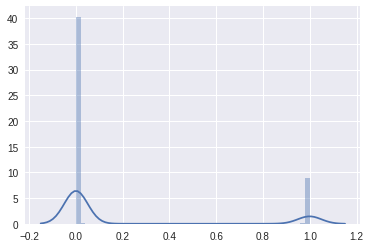

In [31]:
sns.distplot(all_pred)

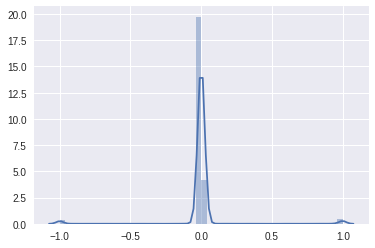

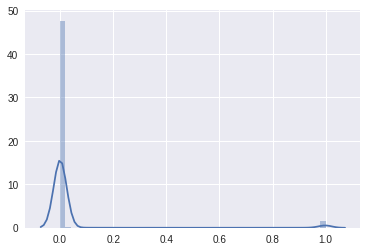

In [18]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(error)
plt.show()
sns.distplot(np.abs(error))

In [34]:
print np.sum(np.abs(error) > 0.01) 1354
print np.sum(np.abs(error) > 0.99) 864
print 861.0/test_total

1354
861
0.0313626926019


In [ ]:
np.abs(error) > 0.99

In [35]:
test_total

27453

In [73]:
generate_predictions_csv(model, 'out1.csv')

In [ ]:
train('model_post1.1_3_32_lr_001.tar', epochs=10, **torch.load('model_post1_3_32_lr_001.tar'))

---Epoch 8---


In [80]:
torch.load('model_3_32_lr_001.tar')

{'criterion': CrossEntropyLoss (
 ), 'cur_epoch': 4, 'model': Model1 (
   (drug_embedding): Embedding(2870, 30)
   (dx_embedding): Embedding(12, 5)
   (gru1): GRU(39, 32, num_layers=3, batch_first=True)
   (dense1): Linear (32 -> 2)
   (softmax): Softmax ()
 ), 'optimizer': <torch.optim.adam.Adam at 0x7f23016a2350>, 'test_aucs': [0.9497745120551091,
  0.95737772101378837,
  0.96352282510260245,
  0.97322535701846047], 'test_losses': [0.35393751389666983,
  0.35761409787089349,
  0.35281944691292533,
  0.34829183176775053], 'train_losses': [0.37126914617345386,
  0.33828777079089706,
  0.33836713117440947,
  0.39558140579214862]}

In [12]:
def validate_all(model):
    all_true = np.zeros((test_total, 2))
    all_pred = np.zeros((test_total, 2))
    total_test_loss = 0
    i = 0
    for b in tqdm_notebook(test_pt_by_len):
        hidden, inp, target = prepare_input(np.array(test_pt_by_len[b]))
        target2 = target[:]
        hidden, inp, posts, drugs, dxs, target = torchify_batch(hidden, inp, target)
        out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda())

        target.cuda()

        loss = criterion(out, target.cuda())
        out_np = out.data.cpu().numpy()
        for j in xrange(target2.shape[0]):
            all_true[i, int(target2[j])] = 1
            all_pred[i] = out_np[j]
            i += 1
        total_test_loss += loss.data.cpu().numpy()[0]
    test_loss = total_test_loss/288
    test_auc = roc_auc_score(all_true, all_pred)
    return test_loss, test_auc

validate_all(model)

Widget Javascript not detected.  It may not be installed or enabled properly.


(0.35821641802842302, 0.94314307203172887)

In [7]:
test_total

27453